In [1]:
#importing tensorflow stuffs
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Flatten,Conv2D,Dropout,MaxPooling2D,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.applications import VGG19, ResNet50, InceptionV3

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import shutil
import glob
import matplotlib.pyplot as plt
import cv2
import logging
from numpy import loadtxt
from tensorflow.keras.models import load_model

In [3]:
#create the directory structure
base_dir='F:/4th year project/flower_cnn/dataset/flowers'

In [4]:
#classes or labels
classes=['daisy','dandelion','rose','sunflower','tulip']

In [5]:
#for opening images
for x in classes:
    images=[]
    flower_dir=os.path.join(base_dir,x)
    print(flower_dir)
    for img in glob.glob(flower_dir + '/*.jpg'):#parameter should be string pattern
        images.append(img)
    print("{} : {} images".format(x,len(images)))
    
    #deviding the images into trainning and testing set(80% of then are in trainning set and remaining are in validation set)
    
    num_train=int(len(images)*0.8)
    train_set,val_set=images[:num_train],images[num_train:]
    
    #moving the images to train set
    
    for t in train_set:
        if not os.path.exists(os.path.join(base_dir,'train',x)):
            os.makedirs(os.path.join(base_dir,'train',x))
        shutil.move(t,os.path.join(base_dir,'train',x))
    
    #moving the images to validation set
    
    for val in val_set:
        if not os.path.exists(os.path.join(base_dir,'validation',x)):
            os.makedirs(os.path.join(base_dir,'validation',x))
        shutil.move(val,os.path.join(base_dir,'validation',x))

F:/4th year project/flower_cnn/dataset/flowers\daisy
daisy : 0 images
F:/4th year project/flower_cnn/dataset/flowers\dandelion
dandelion : 0 images
F:/4th year project/flower_cnn/dataset/flowers\rose
rose : 0 images
F:/4th year project/flower_cnn/dataset/flowers\sunflower
sunflower : 0 images
F:/4th year project/flower_cnn/dataset/flowers\tulip
tulip : 0 images


In [6]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')

In [7]:
batch_size=32
img_shape=150

In [8]:
img_gen_train=ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=.15,
    height_shift_range=.15,
    horizontal_flip=True,
    zoom_range=0.5
)

train_data_gen=img_gen_train.flow_from_directory(
    batch_size=batch_size,#no of images to be yeilded from the generator per batch
    directory=train_dir,
    shuffle=True,
    target_size=(img_shape,img_shape),
    class_mode='sparse'
)

Found 3457 images belonging to 5 classes.


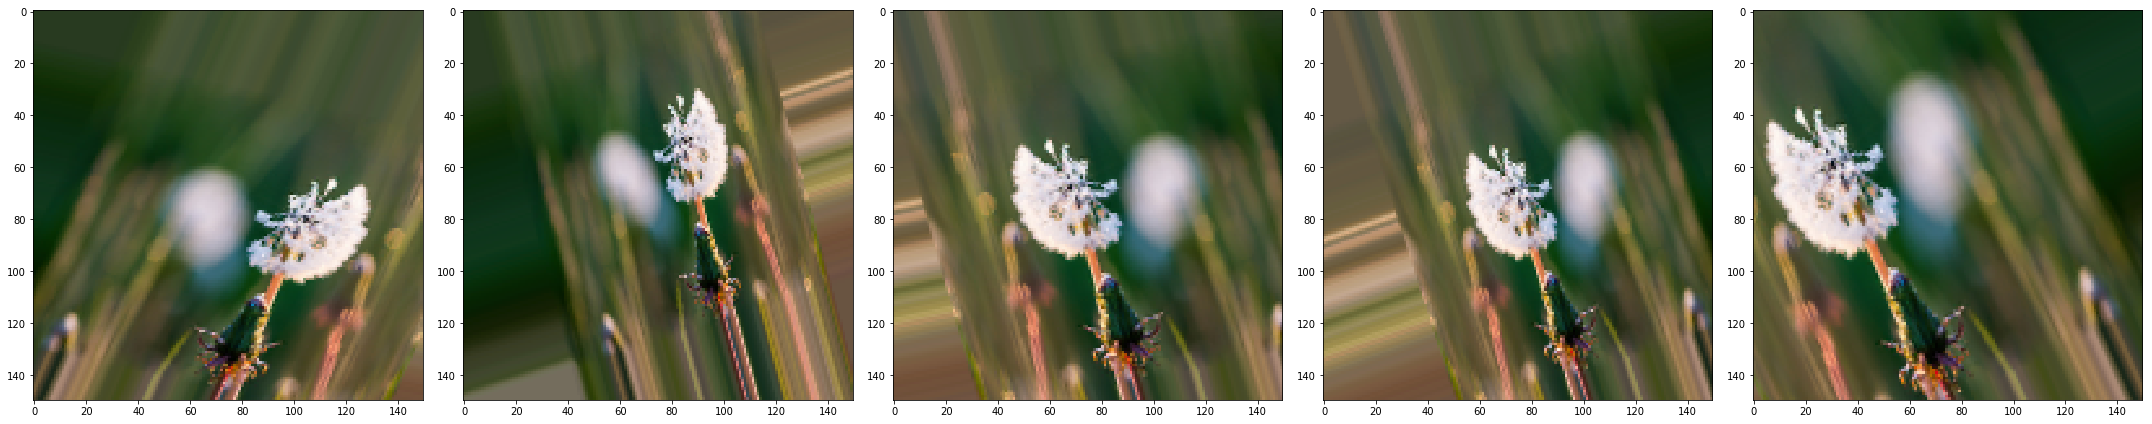

In [9]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1,5 , figsize=(30,30))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

#show the augmented images
augmented_images=[]
for i in range(5):
    augmented_images.append(train_data_gen[0][0][0])
plotImages(augmented_images)

In [10]:
def create_model_from_ResNet50():

    model = Sequential()

    model.add(ResNet50(include_top=False, pooling='avg', weights='resnet50_weights_notop.h5'))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(2048, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(len(classes), activation='softmax'))

    model.layers[0].trainable = False
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc']) # optimizer=RMSprop(lr=0.001)
    
    return model

In [11]:
#image data generator for validation set

image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=val_dir,
                                                 target_size=(img_shape, img_shape),
                                                 class_mode='sparse')

Found 866 images belonging to 5 classes.


In [12]:
model_ResNet50 = create_model_from_ResNet50()
model_ResNet50.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
batch_normalization_v1 (Batc (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 2048)              4196352   
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 2048)              8192      
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
batc

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_1 = ModelCheckpoint("model_resnet1.h5",
                             monitor="val_acc",
                             mode="max",
                             save_best_only = True,
                             verbose=1)

callbacks_1 = [checkpoint_1]

In [14]:
import time
start = time.time()

model_ResNet50_info = model_ResNet50.fit_generator(
    generator=train_data_gen, 
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(batch_size))),   
    epochs=20, 
    validation_steps=int(np.ceil(val_data_gen.n / float(batch_size))),
    validation_data=val_data_gen, 
    callbacks = callbacks_1,
    verbose=1
)

end = time.time()
duration = end - start
#print ('\n model_ResNet50 took %0.2f seconds (%0.1f minutes) to train for epochs'%(duration, duration/60) )

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
28/28 [==============================] - 104s 4s/step - loss: 2.5171 - acc: 0.1801

Epoch 00001: val_acc improved from -inf to 0.18014, saving model to model_resnet1.h5
109/109 [==============================] - 1216s 11s/step - loss: 1.4417 - acc: 0.6830 - val_loss: 2.5171 - val_acc: 0.1801
Epoch 2/20
28/28 [==============================] - 101s 4s/step - loss: 5.5055 - acc: 0.1813

Epoch 00002: val_acc improved from 0.18014 to 0.18129, saving model to model_resnet1.h5
109/109 [==============================] - 1156s 11s/step - loss: 0.6382 - acc: 0.7793 - val_loss: 5.5055 - val_acc: 0.1813
Epoch 3/20
28/28 [==============================] - 101s 4s/step - loss: 4.2555 - acc: 0.1917

Epoch 00003: val_acc improved from 0.18129 to 0.19169, saving model to model_resnet1.h5
109/109 [==============================] - 1155s 11s/step - loss: 0.5783 - acc: 0.7992 - val_loss: 4.2555 - val_acc: 0.1917
Epoch 4/20
28/28 [================

In [15]:
model_ResNet50_info.save('F:/4th year project/flower_cnn/dataset/flowers/model_flower_resnet1.h5')

AttributeError: 'History' object has no attribute 'save'

In [16]:
model=load_model('model_resnet1.h5')

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
batch_normalization_v1 (Batc (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 2048)              4196352   
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 2048)              8192      
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
batch_normalization_v1_2 (Ba (None, 1024)              4096      
__________

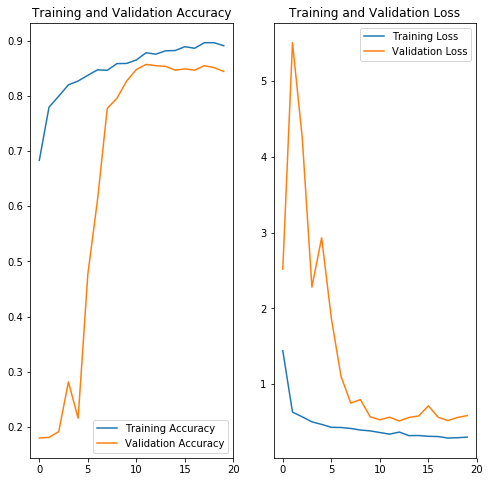

In [18]:
acc = model_ResNet50_info.history['acc']
val_acc =model_ResNet50_info.history['val_acc']

loss = model_ResNet50_info.history['loss']
val_loss = model_ResNet50_info.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
def predict_one_image(img, model):
    img = cv2.resize(img, (150, 150), interpolation = cv2.INTER_CUBIC)
    img = np.reshape(img, (1, 150, 150, 3))
    img = img/255.
    pred = model.predict(img)
    #class_num = np.argmax(pred)
    return pred

daisy 0%
dandelion 0%
rose 0%
sunflower 0%
tulip 99%


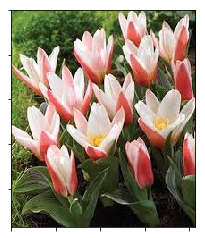

In [19]:
test_img = cv2.imread('C:/Users/ARPAN/Downloads/pictures/tulip.jpg')
pred = predict_one_image(test_img, model)
for i in range(5):
    print('%s %d%%' % (classes[i], round(pred[0][i], 2) * 100))
_, ax = plt.subplots(1)
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
# Turn off tick labels
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.grid('off')
plt.show()